<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></li></ul></div>

# Прогнозирование оттока клиентов

**Цель проекта**: разработка модели прогнозирования оттока клиентов банка на основе исторических данных о поведении клиентов и расторжении договоров с банком. Минимально необходимая для модели метрика F1  - 0,59. 

**Основные этапы проекта**:

- Изучение и предобработка предоставленных данных
- Разбиение данных на выборки, нормализация количественных данных
- Выбор и построение моделей классификации (дерево решений, случайный лес, логистическая регрессия) без учёта дисбаланса классов
- Исследование дисбаланса классов, корректировка моделей с учётом дисбаланса
- Проверка лучших моделей на тестовой выборке, анализ итоговых метрик
- Общий вывод и рекомендации

**Датасет содержит следующие данные**:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

## Подготовка данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, classification_report
import numpy as np
from sklearn.utils import shuffle

churn = pd.read_csv('/Churn.csv')
print(churn.info())
churn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Типы данных столбцам в основном присвоены оптимально, однако в столбце `Tenure` с данными о том, сколько лет клиент обслуживается в банке, тип лучше заменить на целочисленный. В этом же столбце имеется 909 пропусков, которые необходимо обработать. Первые три столбца с номером, ID клиента и его фамилией персонализированы и не влияют на вероятность ухода клиента, предлагается исключить их из дальнейшего рассмотрения. 

Но сперва проверим таблицу на наличие явных дубликатов:

In [3]:
churn.duplicated().sum()

0

Дубликатов нет. Удалим первые 3 столбца:

In [4]:
churn = churn.drop(churn.iloc[:, 0:3], axis=1)
churn.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


Рассмотрим параметры клиентов в каждом столбце подробнее.

**Кредитный рейтинг**: 

In [5]:
churn['CreditScore'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

**Страна проживания**: 

In [6]:
churn['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

**Пол**: 

In [7]:
churn['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

**Возраст клиента**: 

In [8]:
churn['Age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64

**Сколько лет клиент обслуживается в банке**: этот столбец содержит пропуски.

In [9]:
print(churn['Tenure'].describe())
churn.loc[churn['Tenure'].isna()]

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...
9944,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Посмотрим на распределение клиентов по количеству лет, в течение которых они обслуживаются в банке:

In [10]:
churn['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

Группа пользователей, которые пользуются услугами банка менее года, содержит значительно меньше наблюдений, чем остальные группы, тогда как в реальных выборках должно наблюбдаться обратное: число клиентов должно уменьшаться с каждым годом, поскольку далеко не все клиенты верны одному банку на протяжении десятилетий. Можно предположить, что пропущенные значения принадлежат именно к этой группе. В "боевых" условиях, конечно, стоит уточнить принадлежность этих пропусков у бизнеса. 

Заменим пропуски на 0 и приведём данные к целочисленному типу.

In [11]:
churn['Tenure'] = churn['Tenure'].fillna(0)
churn['Tenure'] = churn['Tenure'].astype(int)
churn['Tenure'].describe()

count    10000.000000
mean         4.543400
std          3.111573
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         10.000000
Name: Tenure, dtype: float64

**Баланс на счёте клиента**: 

In [12]:
churn['Balance'].describe()

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: Balance, dtype: float64

**Количество продуктов, которыми пользуется клиент**:

In [13]:
churn['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

**Пользуется ли клиент кредитной картой**:

In [14]:
churn['HasCrCard'].value_counts()

1    7055
0    2945
Name: HasCrCard, dtype: int64

**Активность клиента**:

In [15]:
churn['IsActiveMember'].value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

**Предполагаемая зарплата**:

In [16]:
churn['EstimatedSalary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64

И, наконец, целевой признак - **факт ухода клиента** (1 - клиент ушёл, 0 - обслуживается в банке)

In [17]:
churn['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Теперь закодируем категориальные признаки (столбцы `Geography` и `Gender`) с помощью метода One-Hot Encoding, который работает со всеми моделями классификации:

In [18]:
churn_ohe = pd.get_dummies(churn, drop_first = True)
churn_ohe.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0


### Вывод

В предоставленной таблице 10 000 строк и 14 столбцов.

В рамках предобратботки осуществлено следующее:
- из рассмотрения исключены 3 столбца: с порядковым номером, уникальным ID и фамилией клиента;
- пропуски в столбце с данными о сроках обслуживания клиента в банке заменены на 0, тип приведён к целочисленному;
- закодированы категориальные признаки `Geography` и `Gender`.

После предобработки таблица содержит 10 000 наблюдений, 10 влияющих признаков и один бинарный целевой. 

## Исследование задачи

In [19]:
churn['Exited'].value_counts() / churn['Exited'].value_counts().sum()

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Уже на этапе предобработки мы увидели, что в предоставленных данных классы целевого признака не сбалансированы: ушло из банка 20% проанализированных клиентов, осталось - 80%. Но на данном этапе построение модели будет вестись без корректировки на дисбаланс.

Разобьём данные на обучающую, валидационную и тестовую выборки в пропорции 60/20/20:

In [20]:
# целевой признак:
target = churn_ohe['Exited']
# влияющие признаки:
features = churn_ohe.drop('Exited', axis = 1)

# сперва выделим 60% обучающих данных:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, test_size = 0.4, 
                                                                             random_state = 12345)
# затем оставшиеся 40% разделим на две выборки по 20%:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test, test_size = 0.5, 
                                                                             random_state = 12345)
print('Размер тренировочной выборки:', target_train.shape)
print('Размер валидационной выборки:', target_valid.shape)
print('Размер тестовой выборки:', target_test.shape)

Размер тренировочной выборки: (6000,)
Размер валидационной выборки: (2000,)
Размер тестовой выборки: (2000,)


In [24]:
print(features_train.head())

      CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
7479          567   35       8  153137.74              1          1   
3411          711   37       8  113899.92              1          0   
6027          850   44       3  140393.65              2          0   
1247          512   24       6       0.00              2          1   
3716          665   27       2  147435.96              1          0   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
7479               0         88659.07                  0                1   
3411               0         80215.20                  0                0   
6027               1        186285.52                  1                0   
1247               0         37654.31                  0                0   
3716               0        187508.06                  1                0   

      Gender_Male  
7479            1  
3411            0  
6027            1  
1247            1  
3716      

Масштабируем количественные данные (столбцы CreditScore, Age, Tenure, Balance, NumOfProducts и EstimatedSalary):

In [25]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
display(features_train.head(3))
display(features_valid.head(3))
display(features_test.head(3))

<ipython-input-25-e48ea885055e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
c:\program files\python38\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-25-e48ea885055e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,-0.886751,-0.373192,1.104696,1.232271,-0.891560,1,0,-0.187705,0,1,1
3411,0.608663,-0.183385,1.104696,0.600563,-0.891560,0,0,-0.333945,0,0,0
6027,2.052152,0.480939,-0.503694,1.027098,0.830152,0,1,1.503095,1,0,1


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8532,-0.699824,-0.373192,-0.825373,-1.233163,0.830152,1,0,-0.015173,0,0,0
5799,-0.284431,0.575842,-0.503694,-1.233163,-0.891560,1,1,1.471724,0,0,0
5511,0.151731,-0.657902,-1.468729,0.438711,-0.891560,1,0,-1.367107,1,0,1


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7041,-2.226392,-0.088482,-0.825373,-1.233163,0.830152,1,0,0.647083,0,0,1
5709,-0.087120,0.006422,1.426375,-1.233163,-0.891560,1,0,-1.658410,0,0,0
7117,-0.917905,-0.752805,0.139662,0.722307,-0.891560,1,1,-1.369334,0,1,1


Поскольку целевой признак в нашем случае - бинарная переменная, перед нами стоит задача классификации. Для этого будем использовать следующие модели:

- дерево решений
- случайный лес
- логистическую регрессию.

Начнём с построения оптимальной модели **дерева решений**. Подберём оптимальную при различной максимальной глубине дерева - от 1 до 20. Для оценки качества модели будем использовать показатель F1, дополнительно посчитаем площадь под ROC-кривой.

In [22]:
# Объявим функцию для вычиления F1 и AUC-ROC
def F1_AUC(model):
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    probabilities_one = model.predict_proba(features_valid)[:,1]
    # вычисляем F1:
    F1 = f1_score(target_valid, predictions)

    # вычисляем AUC_ROC:
    auc_roc = roc_auc_score(target_valid, probabilities_one)
    return F1, auc_roc

In [23]:
f1_base = []
auc_base = []
best_tree_depth = 0
max_tree_f1 = 0
max_tree_auc = 0

# выбор оптимальной модели дерева решений:
for depth in range(1,20):
    tree_model = DecisionTreeClassifier(random_state = 1, max_depth = depth, min_samples_leaf = 2)
    F1 = F1_AUC(tree_model)[0]
    auc_roc = F1_AUC(tree_model)[1]
    if F1 > max_tree_f1:
        best_tree_depth = depth
        max_tree_f1 = F1
        max_tree_auc = auc_roc
        best_tree_model = tree_model
print('Показатель F1 лучшей модели дерева решений: ', max_tree_f1.round(2), ' при максимальной глубине дерева ', best_tree_depth, 
      '\n', 'Площадь под ROC-кривой лучшей модели дерева решений: ', max_tree_auc.round(2), sep = '')

# для сводной таблицы запомним результаты:
f1_base.append(max_tree_f1.round(2))
auc_base.append(max_tree_auc.round(2))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Показатель F1 лучшей модели дерева решений: 0.57 при максимальной глубине дерева 6
Площадь под ROC-кривой лучшей модели дерева решений: 0.82


Следующей построим модель **случайного леса**. В качестве гиперпараметров зададим диапазон максимальной глубины дерева от 1 до 20, количество деревьев - от 20 до 80 с шагом 10, минимальное количество "листьев" - 2.

In [24]:
best_forest_depth = 0
max_forest_f1 = 0
best_est = 0
max_forest_auc = 0
for depth in range(1,20):
    for est in range(20, 80, 10):
        forest_model = RandomForestClassifier(random_state = 1, max_depth = depth, min_samples_leaf = 2, n_estimators = est)
        F1 = F1_AUC(forest_model)[0]
        auc_roc = F1_AUC(forest_model)[1]
        if F1 > max_forest_f1:
            best_forest_depth = depth
            max_forest_f1 = F1
            best_est = est
            max_forest_auc = auc_roc
            best_forest_model = forest_model
print('Показатель F1 лучшей модели случайного леса: ', max_forest_f1.round(2), ' при максимальной глубине дерева ', 
      best_forest_depth, ' и количестве деревьев ', best_est, '\n', 
      'Площадь под ROC-кривой лучшей модели дерева решений: ', max_forest_auc.round(2), sep = '')

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

Показатель F1 лучшей модели случайного леса: 0.59 при максимальной глубине дерева 14 и количестве деревьев 50
Площадь под ROC-кривой лучшей модели дерева решений: 0.84


In [25]:
f1_base.append(max_forest_f1.round(2))
auc_base.append(max_forest_auc.round(2))

Осталось построить модель **логистической регрессии**:

In [26]:
logist_model = LogisticRegression(random_state = 1, solver = 'liblinear')
f1_logist = F1_AUC(logist_model)[0]
auc_logist = F1_AUC(logist_model)[1]
print('Показатель F1 логистической регрессии равен', f1_logist.round(2))

f1_base.append(f1_logist.round(2))
auc_base.append(auc_logist.round(2))

Показатель F1 логистической регрессии равен 0.33


Сформируем итоговую таблицу с оценкой качества построенных моделей:

In [27]:
result = pd.DataFrame(np.array([f1_base, auc_base]), columns=['Tree', 'Forest', 'LogitR'], index = ['F1', 'AUC-ROC'])
result

,Tree,Forest,LogitR
F1,0.57,0.59,0.33
AUC-ROC,0.82,0.84,0.76


### Вывод
Целевой показатель F1, поставленный для нас бизнесом - 0,59, и его удалось достичь уже на данном этапе, без учёта дисбаланса классов. Лучший показатель F1 - у модели случайного леса - 0,59. Худший - у модели логистической регрессии - всего 0,33. Площадь под ROC-кривой максимальна также у модели случайного леса - 0,84. 

На следующем этапе мы скорректируем модели с учётом имеющегося дисбаланса классов.

## Борьба с дисбалансом

Попробуем скорректировать наши модели исходя из имеющегося дисбаланса с помощью следующих методов:
- взвешивание
- upsampling
- downsampling

---
Внесём в модели поправку на дисбаланс классов с помощью **взвешивания** и проанализируем результаты:

In [28]:
# дерево решений

balanced_tree_model = DecisionTreeClassifier(random_state = 1, max_depth = best_tree_depth, 
                                         min_samples_leaf = 2, class_weight = 'balanced')
f1_bal = []
auc_bal = []
def F1_AUC_bal(model, name):
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    probabilities_one = model.predict_proba(features_valid)[:,1]
    # вычисляем F1:
    F1 = f1_score(target_valid, predictions)
    f1_bal.append(F1.round(2))

    # вычисляем AUC_ROC:
    auc_roc = roc_auc_score(target_valid, probabilities_one)
    auc_bal.append(auc_roc.round(2))
    print('Применение взвешивания:', '\n', 'Показатель F1 модели ', name, ' равен: ', F1.round(2), '\n', 
         'Показатель AUC_ROC модели ', name, ' равен: ', auc_roc.round(2), sep = '')

F1_AUC_bal(balanced_tree_model, 'дерева решений')

Применение взвешивания:
Показатель F1 модели дерева решений равен: 0.56
Показатель AUC_ROC модели дерева решений равен: 0.81


In [29]:
# случайный лес
balanced_forest_model = RandomForestClassifier(random_state = 1, n_estimators = best_est, max_depth = best_forest_depth, 
                                         min_samples_leaf = 2, class_weight = 'balanced')
F1_AUC_bal(balanced_forest_model, 'случайного леса с учётом дисбаланса классов')

Применение взвешивания:
Показатель F1 модели случайного леса с учётом дисбаланса классов равен: 0.62
Показатель AUC_ROC модели случайного леса с учётом дисбаланса классов равен: 0.85


In [30]:
balanced_logist_model = LogisticRegression(random_state = 1, solver = 'liblinear', class_weight = 'balanced')
F1_AUC_bal(balanced_logist_model, 'логит-регрессии с учётом дисбаланса классов')

Применение взвешивания:
Показатель F1 модели логит-регрессии с учётом дисбаланса классов равен: 0.49
Показатель AUC_ROC модели логит-регрессии с учётом дисбаланса классов равен: 0.76


Поправка на дисбаланс с помощью взвешивания позволила нам улучшить F1 для двух моделей: случайный лес и логистическая регрессия. 

------
Попробуем увеличить выборку (**upsamling**):

In [26]:
features_0 = features_train[target_train == 0]
features_1 = features_train[target_train == 1]
target_0 = target_train[target_train == 0]
target_1 = target_train[target_train == 1]
repeat = 4
features_up = pd.concat([features_0] + [features_1]*repeat)
target_up = pd.concat([target_0] + [target_1]*repeat)
features_up, target_up = shuffle(features_up, target_up, random_state = 1)
print(features_up.shape)
print(target_up.shape)

(9588, 11)
(9588,)
      CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
7479    -0.886751 -0.373192  1.104696  1.232271      -0.891560          1   
3411     0.608663 -0.183385  1.104696  0.600563      -0.891560          0   
6027     2.052152  0.480939 -0.503694  1.027098       0.830152          0   
1247    -1.457915 -1.417129  0.461340 -1.233163       0.830152          1   
3716     0.130961 -1.132419 -0.825373  1.140475      -0.891560          0   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
7479               0        -0.187705                  0                1   
3411               0        -0.333945                  0                0   
6027               1         1.503095                  1                0   
1247               0        -1.071061                  0                0   
3716               0         1.524268                  1                0   

      Gender_Male  
7479            1  
3411           

Обучим модели на новых данных:

In [32]:
# Дерево решений
f1_up = []
auc_up = []
# функция для вычисления метрик
def F1_AUC_up(model, name):
    model.fit(features_up, target_up)
    predictions = model.predict(features_valid)
    probabilities_one = model.predict_proba(features_valid)[:,1]
    F1 = f1_score(target_valid, predictions)
    f1_up.append(F1.round(2))
    auc_roc = roc_auc_score(target_valid, probabilities_one)
    auc_up.append(auc_roc.round(2))
    print('Применение метода upsamling:', '\n', 'Показатель F1 модели ', name, ' равен: ', F1.round(2), '\n', 
         'Показатель AUC_ROC модели ', name, ' равен: ', auc_roc.round(2), sep = '')
F1_AUC_up(best_tree_model, 'дерево решений')

Применение метода upsamling:
Показатель F1 модели дерево решений равен: 0.56
Показатель AUC_ROC модели дерево решений равен: 0.81


In [33]:
# случайный лес
F1_AUC_up(best_forest_model, 'случайного леса')

Применение метода upsamling:
Показатель F1 модели случайного леса равен: 0.63
Показатель AUC_ROC модели случайного леса равен: 0.85


In [34]:
# логит-регрессия
F1_AUC_up(logist_model, 'логит-регрессии')

Применение метода upsamling:
Показатель F1 модели логит-регрессии равен: 0.49
Показатель AUC_ROC модели логит-регрессии равен: 0.76


Результаты получили практически те же, что и при обучении с применением взвешивания.

---
Осталось попробовать метод уменьшения выборки (**downsamling**):

In [30]:
fraction = 0.25
features_down = pd.concat([features_0.sample(frac = fraction, random_state = 1)] + [features_1])
target_down = pd.concat([target_0.sample(frac = fraction, random_state = 456)] + [target_1])
features_down= shuffle(features_down, random_state = 1)
target_down = shuffle(target_down, random_state = 1)
print(features_down.shape)
print(target_down.shape)
print(features_down.head())
print(target_down.head())

(2397, 11)
(2397,)
      CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
5558     0.255579 -0.468095 -1.468729  0.807111      -0.891560          1   
441      1.429063 -0.752805  1.426375 -1.233163       0.830152          1   
3485    -0.502513 -0.562998 -0.503694 -1.233163      -0.891560          1   
3878    -1.312528 -0.657902  0.461340  0.890981       0.830152          1   
7800     0.473660  1.240166 -1.147051  0.504077      -0.891560          1   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
5558               1        -1.271060                  1                0   
441                0        -0.266201                  0                0   
3485               0        -0.992834                  0                0   
3878               1        -1.692095                  1                0   
7800               0         1.201758                  1                0   

      Gender_Male  
5558            1  
441            

In [36]:
f1_down = []
auc_down = []
# функция для вычисления метрик
def F1_AUC_down(model, name):
    model.fit(features_down, target_down)
    predictions = model.predict(features_valid)
    probabilities_one = model.predict_proba(features_valid)[:,1]
    F1 = f1_score(target_valid, predictions)
    f1_down.append(F1.round(2))
    auc_roc = roc_auc_score(target_valid, probabilities_one)
    auc_down.append(auc_roc.round(2))
    print('Применение downsampling:', '\n', 'Показатель F1 модели ', name, ' равен: ', F1.round(2), '\n', 
         'Показатель AUC_ROC модели ', name, ' равен: ', auc_roc.round(2), sep = '')

# Дерево решений
F1_AUC_down(best_tree_model, 'дерево решений')

Применение downsampling:
Показатель F1 модели дерево решений равен: 0.56
Показатель AUC_ROC модели дерево решений равен: 0.82


In [37]:
# случайный лес
F1_AUC_down(best_forest_model, 'случайного леса')

Применение downsampling:
Показатель F1 модели случайного леса равен: 0.57
Показатель AUC_ROC модели случайного леса равен: 0.83


In [38]:
# логит-регрессия
F1_AUC_down(logist_model, 'логит-регрессии')

Применение downsampling:
Показатель F1 модели логит-регрессии равен: 0.49
Показатель AUC_ROC модели логит-регрессии равен: 0.76


In [39]:
result_F1 = pd.DataFrame(np.array([f1_base, f1_bal, f1_up, f1_down]), columns=['Tree', 'Forest', 'LogitR'], 
                         index = ['F1 базовой модели', 'F1 взвешенный', 'F1 upsample', 'F1 downsample'])
display(result_F1)

result_AUC = pd.DataFrame(np.array([auc_base, auc_bal, auc_up, auc_down]), columns=['Tree', 'Forest', 'LogitR'], 
                         index = ['AUC-ROC базовой модели', 'AUC-ROC взвешенный', 'AUC-ROC upsample', 'AUC-ROC downsample'])
display(result_AUC)

,Tree,Forest,LogitR
F1 базовой модели,0.57,0.59,0.33
F1 взвешенный,0.56,0.62,0.49
F1 upsample,0.56,0.63,0.49
F1 downsample,0.56,0.57,0.49


,Tree,Forest,LogitR
AUC-ROC базовой модели,0.82,0.84,0.76
AUC-ROC взвешенный,0.81,0.85,0.76
AUC-ROC upsample,0.81,0.85,0.76
AUC-ROC downsample,0.82,0.83,0.76


Как видно из итоговых таблиц с метриками качества моделей, наилучшие результаты показывает модель случайного леса, обученная с помощью метода увеличения выборки: F1 такой модели равен 0,63, площадь под ROC-кривой - 0,85. Практически такие же показатели у модели случайного леса, обученной с помощью взвешивания классов. 

Худшие показатели меры F1 получены при обучении на уменьшенной выборке.

In [40]:
model = RandomForestClassifier(random_state = 1, min_samples_leaf = 2)
parametrs = { 'n_estimators': range (20, 80, 10),
              'max_depth': range (1,20)}
grid = GridSearchCV(model, parametrs, cv=5, scoring = 'f1')
grid.fit(features_train, target_train)
grid.best_params_

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

{'max_depth': 16, 'n_estimators': 50}

In [41]:
grid_model = RandomForestClassifier(random_state = 1, max_depth = grid.best_params_['max_depth'], 
                                    n_estimators = grid.best_params_['n_estimators'], min_samples_leaf = 2)
F1_AUC(grid_model)

(0.5779122541603631, 0.842938500716796)

## Тестирование модели

Протестируем две лучшие модели: 

**1. Модель случайного леса со взвешиванием** 

In [42]:
balanced_forest_model.fit(features_train, target_train)
predictions = balanced_forest_model.predict(features_test)
probabilities_one = balanced_forest_model.predict_proba(features_test)[:,1]
fpr_bal, tpr_bal, thr_bal = roc_curve(target_test, probabilities_one)
F1_balanced = f1_score(target_test, predictions)
auc_roc_balanced = roc_auc_score(target_test, probabilities_one)

**2. Модель случайного леса, обученная с применением upsample**

In [43]:
best_forest_model.fit(features_up, target_up)
predictions = best_forest_model.predict(features_test)
probabilities_one = best_forest_model.predict_proba(features_test)[:,1]
fpr_up, tpr_up, thr_up = roc_curve(target_test, probabilities_one)
F1_upsamle = f1_score(target_test, predictions)
auc_roc_upsamle = roc_auc_score(target_test, probabilities_one)

In [44]:
test_result = pd.DataFrame([[F1_balanced.round(2), F1_upsamle.round(2)], [auc_roc_balanced.round(2), auc_roc_upsamle.round(2)]], 
                           columns=['Forest_balanced', 'Forest_up'], 
                           index = ['F1', 'AUC-ROC'])
display(test_result)

,Forest_balanced,Forest_up
F1,0.61,0.61
AUC-ROC,0.86,0.85


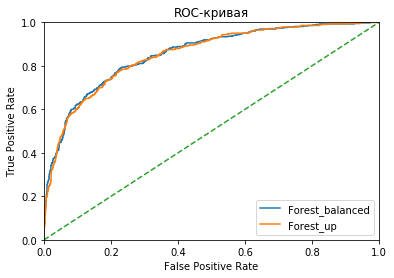

In [45]:
plt.figure()
plt.plot(fpr_bal, tpr_bal, label='Forest_balanced')
plt.plot(fpr_up, tpr_up, label='Forest_up')
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().legend()
plt.title('ROC-кривая')
plt.show()

Мы видим, что на тестовой выборке обе модели показывают одинаковые значения метрики F1: 0,61. Но у модели, обученной на взвешенных классах, чуть больше площадь под ROC-кривой. Для обеих моделей AUC-ROC значительно превышает AUC-ROC для константной модели, что свидетельствует об их адекватности.

In [46]:
print(classification_report(target_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1577
           1       0.61      0.61      0.61       423

    accuracy                           0.83      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.83      0.83      0.83      2000



Доля верных ответов (accuracy) модели на тестовых данных - 83%. Меры precision, recall и взвешенная f1 в целом для модели одинаковы и равны 0,83.

In [47]:
importances = best_forest_model.feature_importances_
forest_importances = pd.Series(importances, index = features_test.columns).sort_values(ascending = False)
print(forest_importances)

Age                  0.276210
NumOfProducts        0.141856
Balance              0.134165
EstimatedSalary      0.119917
CreditScore          0.116154
Tenure               0.069674
IsActiveMember       0.047898
Geography_Germany    0.042071
Gender_Male          0.024784
HasCrCard            0.015798
Geography_Spain      0.011473
dtype: float64


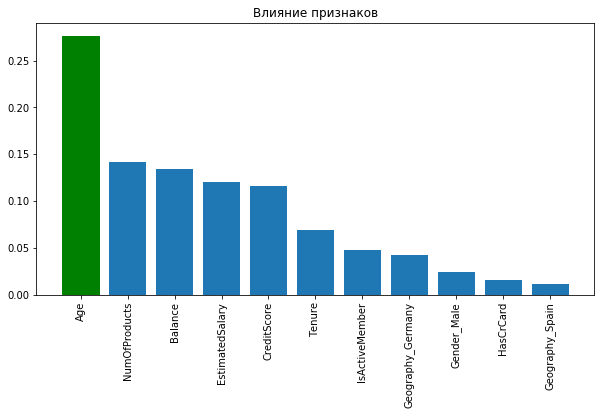

In [48]:
plt.figure(figsize=(10, 5))
bar = plt.bar(forest_importances.index, forest_importances)
bar[0].set_color('g')
plt.title('Влияние признаков')
plt.xticks(rotation = 90)
plt.show()

# Вывод

Перед нами была поставлена задача разработки модели для прогнозирования оттока клиентов банка на основе исторических данных о поведении клиентов и расторжении договоров с банком с метрикой F1 не ниже 0,59. Задача выполнена успешно: метрика F1 для выбранной модели на тестовой выборке равна 0,61. 
В ходе анализа проверялись следующие модели:
- дерево решений
- случайный лес
- логистическая регрессия. 

Анализ моделей проводился в два этапа: без учёта дисбаланса классов и с учётом дисбаланса. Поскольку в предоставленных данных классы существенно разбалансированы, модели показывают лучшие результаты при обучении с учётом имеющегося дисбаланса. 

**Наилучший результат показала модель случайного леса, обученная с применением взвешивания классов со следующими гиперпараметрами**:
- **количество деревьев - 50**
- **максимальная глубина дерева - 14**
- **минимальное количество "листьев" - 2**

Наибольшее влияние на уход клиента из банка оказывает фактор возраста, наименьшее - географическая и половая принадлежность, наличие кредитной карты банка. 